# Guided Project: Predicting Insurance Costs

Solution notebook can be referenced [here](https://github.com/dataquestio/solutions/blob/master/Mission730Solutions.ipynb)

## Table of Contents

* [Introduction](#Introduction)
* [Exploring The Dataset](#Exploring-The-Dataset)
* [Dividing The Data](#Dividing-The-Data)
* [Build The Model](#Build-The-Model)
* [Residual Diagnostics](#Residual-Diagnostics)
* [Interpreting The Model](#Interpreting-The-Model)
* [Final Model Evaluation](#Final-Model-Evaluation)

## Introduction 

For this guided project, we'll be looking at the [Medical Cost Data](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) Set from Kaggle. This dataset contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it.

For our regression problem, we're interested in how these different characteristics relate to the total medical cost. It's a continuous, positive number, which makes it a good candidate for a linear regression. For this guided project, we want to construct the best possible predictive model for the cost, given some information about the patient. Predicting medical costs is an important task because it allows hospitals to predict revenue and plan necessary procedures needed by its patient population.

In [1]:
## Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
insurance = pd.read_csv('insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
insurance.describe(include = 'all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


<AxesSubplot:xlabel='charges', ylabel='Density'>

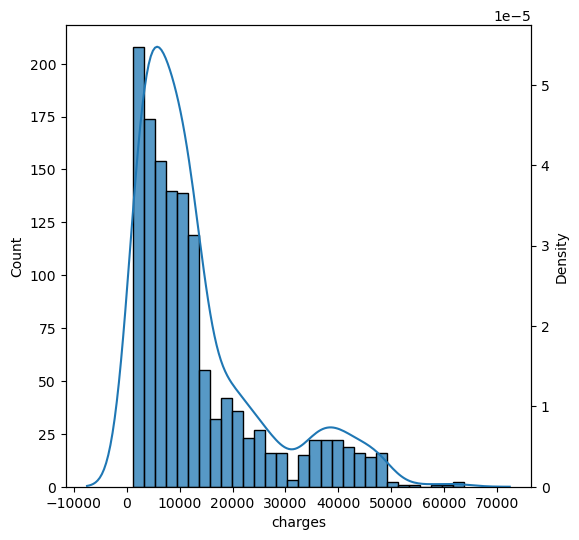

In [5]:
## plot outcome distribution

fig, ax1 = plt.subplots(figsize = (6,6))
sns.histplot(data = insurance, x = 'charges', ax = ax1)
ax2 = ax1.twinx()
sns.kdeplot(data = insurance, x = 'charges', ax = ax2)

<AxesSubplot:xlabel='log_charges', ylabel='Density'>

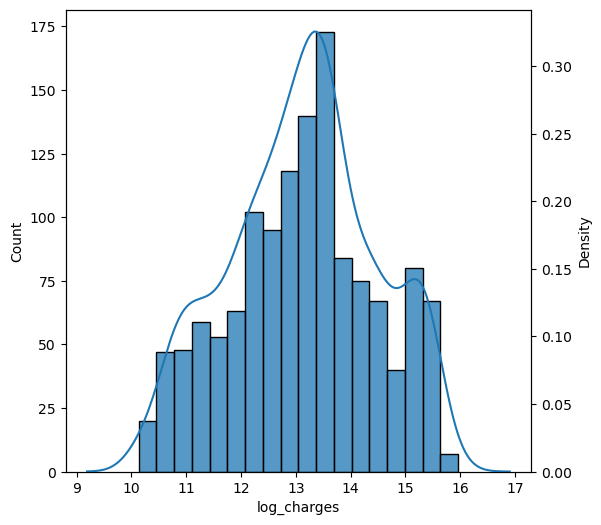

In [6]:
## plot convert to log form

insurance['log_charges'] = np.log2(insurance['charges'])

fig, ax3 = plt.subplots(figsize = (6,6))
sns.histplot(data = insurance, x = 'log_charges', ax = ax3)
ax4 = ax3.twinx()
sns.kdeplot(data = insurance, x = 'log_charges', ax = ax4)

<AxesSubplot:>

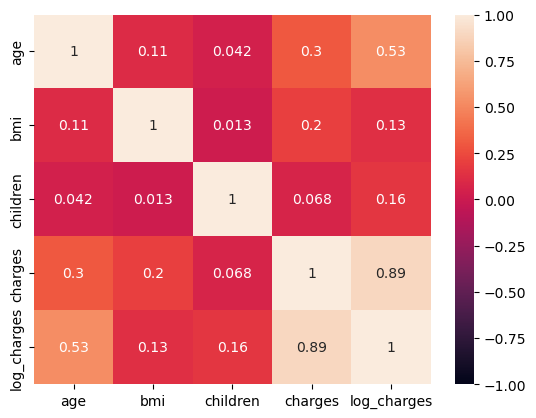

In [7]:
corr = insurance.corr()
sns.heatmap(corr, annot = True, vmax = 1, vmin = -1)

## Exploring The Dataset 

In [8]:
insurance.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'log_charges'],
      dtype='object')

**Columns**

- `age`: age of primary beneficiary
- `sex`: insurance contractor gender, female, male
- `bmi`: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg/m^2) using the ratio of height to weight, ideally 18.5 to 24.9
- `children`: Number of children covered by health insurance / Number of dependents
- `smoker`: Smoking
- `region`: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- `charges`: Individual medical costs billed by health insurance

* We observe that `age (0.3)` and `bmi (0.2)` were both positively correlated with the insurance charge, although the correlation was not quite strong.
* The three numeric predictors `(age, bmi and children)` were not significantly correlated with each other.

In [9]:
categorical_vars = insurance.select_dtypes('object').columns
categorical_vars

Index(['sex', 'smoker', 'region'], dtype='object')

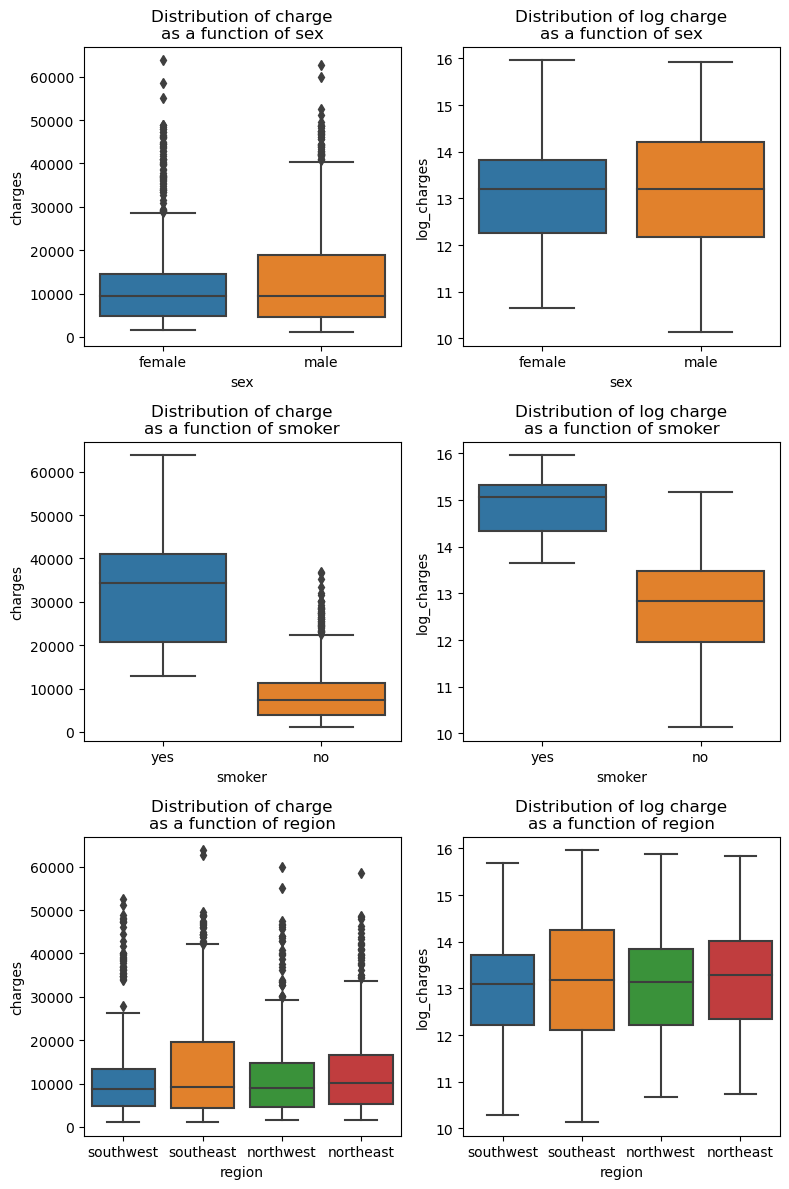

In [10]:
## Check outcome distribution as a function of categorical variables

i = 1
plt.figure(figsize=(8,12))

for var in categorical_vars:
    
    plt.subplot(3,2,i)
    sns.boxplot(data = insurance, x = var, y = 'charges')
    plt.title(f'Distribution of charge\nas a function of {var}')
    
    plt.subplot(3,2,i+1)
    sns.boxplot(data = insurance, x = var, y = 'log_charges')
    plt.title(f'Distribution of log charge\nas a function of {var}')
    
    i+=2
    
plt.tight_layout()

It was shown that a log tranformation was necessary to prevent large values being treated as outliers. 
In addition:

* Sex and region did not seem to result in any significant differences in their charges (or log value).
* For those who smoked, their insurance charges were found generally higher than those who did not smoke.

Therefore, we will choose `smoker` as a feature and ignore `sex` and `region` for now

## Dividing The Data

In [11]:
## Select numeric and categorical features

X = insurance[['age', 'bmi', 'children','smoker']].copy()
y = insurance['log_charges']

## map smoker to numeric

X['smoker'] = X['smoker'].apply(lambda x: 1 if x == 'yes' else 0)
X.head()

,age,bmi,children,smoker
0,19,27.900,0,1
1,18,33.770,1,0
2,28,33.000,3,0
3,33,22.705,0,0
4,32,28.880,0,0


In [12]:
## choosing a 20 % test size

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

##  Build The Model

In [13]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [14]:
lm.coef_

array([0.04956281, 0.01450293, 0.14026864, 2.22592424])

In [15]:
lm.intercept_

10.135055271950915

In [16]:
## MSE on the log basis

y_train_pred = lm.predict(X_train)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = mean_squared_error(y_train, y_train_pred, squared = False)
mae_train = mean_absolute_error(y_train, y_train_pred)

print(f'Mean Squared Error: {mse_train :.4f}\n\
Root Mean Squared Error: {rmse_train :.4f}\nMean Absolute Error: {mae_train :.4f}')

Mean Squared Error: 0.4232
Root Mean Squared Error: 0.6506
Mean Absolute Error: 0.4086


In [17]:
## MSE on the original basis

print(f'On the original scale:\nRoot Mean Squared Error: {np.exp2(-rmse_train) :.4f} - {np.exp2(rmse_train) :.4f}\
\nMean Absolute Error: {np.exp2(-mae_train) :.4f} - {np.exp2(mae_train) :.4f}')

On the original scale:
Root Mean Squared Error: 0.6370 - 1.5698
Mean Absolute Error: 0.7534 - 1.3274


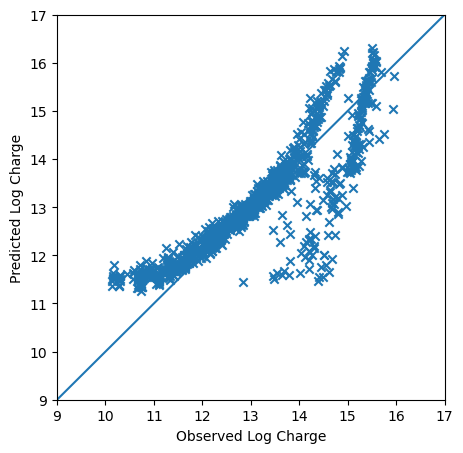

In [18]:
## Plot parity

plt.figure(figsize = (5,5))
plt.scatter(y_train, y_train_pred, marker = 'x')
plt.xlim([9,17])
plt.xlabel('Observed Log Charge')
plt.ylim([9,17])
plt.ylabel('Predicted Log Charge')
plt.axline((0,0), slope = 1)

plt.show()

In [19]:
r2 = r2_score(y_train, y_train_pred)
print(f'R-square score: {r2 :.4f}')

R-square score: 0.7566


## Residual Diagnostics

$$ e_i = Y_i - \hat{Y}_i $$

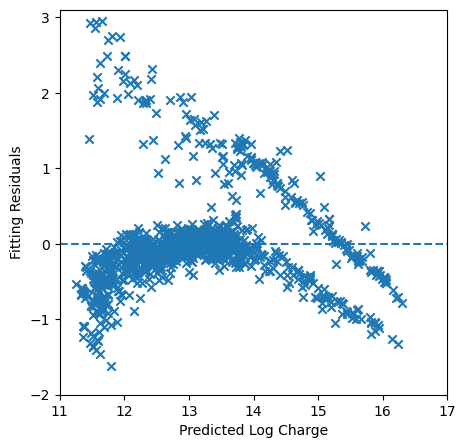

In [20]:
## Plot residue

residual_train = y_train - y_train_pred

plt.figure(figsize = (5,5))
plt.scatter(y_train_pred, residual_train, marker = 'x')
plt.xlim([11,17])
plt.xlabel('Predicted Log Charge')
plt.ylim([-2,3.1])
plt.ylabel('Fitting Residuals')
plt.axhline(y = 0, linestyle = '--')

plt.show()

It should be noted that the residuals did not appear to be uniformly distributed across 0. In particular, the residuals were decreasing into negative values with increasing charge (model overestimating). This might imply some non-linear relationship not properly covered by the linear model.

## Interpreting The Model

In [21]:
features = X.columns
coefs = lm.coef_
percent_change = (np.exp2(coefs) - 1)*100

summary = pd.DataFrame({'Feature': features, 
                        'Fitted Coefficient': coefs, 
                        'Impact per unit increase (%)': percent_change})
summary

,Feature,Fitted Coefficient,Impact per unit increase (%)
0,age,0.049563,3.495125
1,bmi,0.014503,1.010336
2,children,0.140269,10.211031
3,smoker,2.225924,367.810501


The above table showed that: 
* An increase by 1 in `age` and `bmi` resulted in only < 5 % increase in the insurance charge. 
* Such increase in the number of dependents (`children`) will increase the charge by 10 %. 
* Smoking is definitely the most impactful factor, where increase from 0 to 1 (*i.e.*, no to yes) would cause the charge to increase into more than 4x.

It should be noted that the range of these features was not the same. Therefore, an 'increase' by 1 in `age` and `bmi` cannot be compared on the same scale to that in `children`. For example, `children` only varied from `0` to `5`.

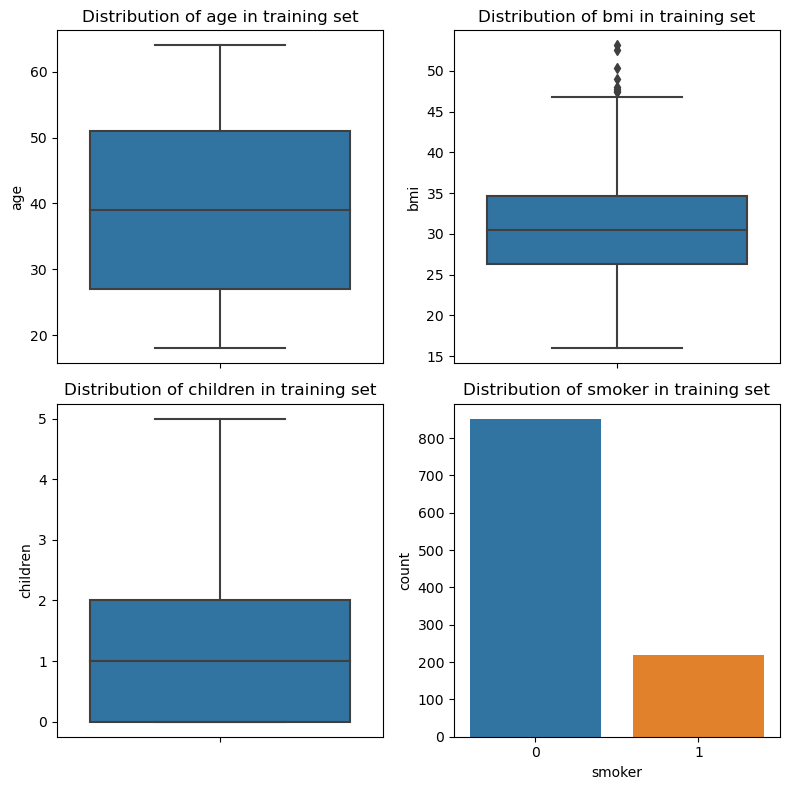

In [22]:
## Plot feature distribution
 
plt.figure(figsize = (8,8))

for i, feature in enumerate(features[:3]):
    
    plt.subplot(2,2,i+1)
    sns.boxplot(data = X_train, y = feature)
    plt.title(f'Distribution of {feature} in training set')
    
plt.subplot(2,2,4)
sns.countplot(data = X_train, x = 'smoker')
plt.title(f'Distribution of smoker in training set')

plt.tight_layout()

## Final Model Evaluation

In [23]:
## MSE on the log basis - for test set

y_test_pred = lm.predict(X_test)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared = False)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f'For the test set:\n\
Mean Squared Error: {mse_test :.4f}\nRoot Mean Squared Error: {rmse_test :.4f}\nMean Absolute Error: {mae_test :.4f}')

For the test set:
Mean Squared Error: 0.3994
Root Mean Squared Error: 0.6320
Mean Absolute Error: 0.4015


In [24]:
## Compare train and test errors

lm_err = pd.DataFrame([[mse_train, rmse_train, mae_train, r2], 
                       [mse_test, rmse_test, mae_test, np.nan]], columns = ['MSE', 'RMSE', 'MAE', 'R2'], 
                     index = ['Train', 'Test'])
lm_err

,MSE,RMSE,MAE,R2
Train,0.423220,0.650554,0.408605,0.7566
Test,0.399425,0.632001,0.401515,NaN


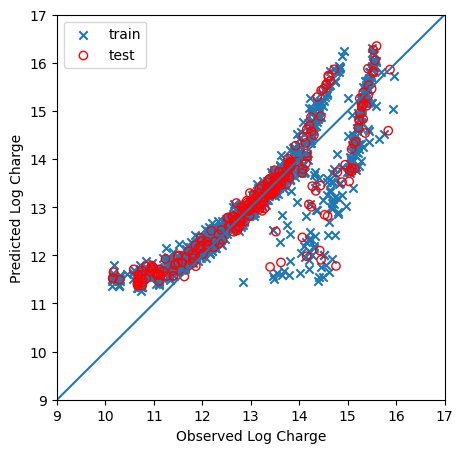

In [25]:
## Plot parity - adding test set

plt.figure(figsize = (5,5))
plt.scatter(y_train, y_train_pred, marker = 'x', label = 'train')
plt.scatter(y_test, y_test_pred, marker = 'o', facecolors = 'none',
            color = 'red', label = 'test')
plt.xlim([9,17])
plt.xlabel('Observed Log Charge')
plt.ylim([9,17])
plt.ylabel('Predicted Log Charge')
plt.axline((0,0), slope = 1)
plt.legend()

plt.show()

With a similar error level observed for both the training and testing dataset, the model was concluded to generalize reasonably well without apparent sign of overfitting.